In [20]:
import pandas as pd

data = pd.read_csv('final_gemid_df.csv')

In [21]:
### een dictionary maken van alle gegevens per persoon; dit is meer voor ons overzicht en niet nodig voor het model

import json

def dict_per_naam(data):
  naam_dict = {}

  for i in range(len(data)):
    row = data.iloc[i].to_dict()

    for key, value in row.items():
        if isinstance(value, pd.Timestamp):
            row[key] = value.strftime('%Y-%m-%d')

    name = row.pop('unique_naam')
    constants = {key: row.pop(key) for key in ['ervaring', 'binary_geslacht', 'binary_gewichtsklasse', '2k tijd']}

    if name not in naam_dict:
        naam_dict[name] = {'gegevens': constants, 'tijden': []}

    tijd_data = {key: row[key] for key in ['binary_trainingtype', '500_split']}
    naam_dict[name]['tijden'].append(tijd_data)

  print(json.dumps(naam_dict, indent=4, sort_keys=False))

  return naam_dict

data_dict = dict_per_naam(data)
print(len(data_dict))

{
    "z47_2018": {
        "gegevens": {
            "ervaring": 1,
            "binary_geslacht": 0,
            "binary_gewichtsklasse": 1,
            "2k tijd": 379.9
        },
        "tijden": [
            {
                "binary_trainingtype": 0,
                "500_split": 104.6
            },
            {
                "binary_trainingtype": 0,
                "500_split": 104.7
            },
            {
                "binary_trainingtype": 0,
                "500_split": 104.3
            },
            {
                "binary_trainingtype": 0,
                "500_split": 104.0
            },
            {
                "binary_trainingtype": 0,
                "500_split": 104.1
            },
            {
                "binary_trainingtype": 10,
                "500_split": 115.5
            },
            {
                "binary_trainingtype": 10,
                "500_split": 117.0
            },
            {
                "binary_trainingtype": 

In [22]:
import pandas as pd
import numpy as np

# Flatten dictionary while preserving binary_trainingtype
def preprocess_data_with_trainingtype(data_dict):
    rows = []
    
    for name, person_data in data_dict.items():
        gegevens = person_data['gegevens']
        tijden = person_data['tijden']
        
        # Create a dictionary to store average splits per binary_trainingtype
        split_per_type = {}
        for training in tijden:
            training_type = training['binary_trainingtype']
            if training_type not in split_per_type:
                split_per_type[training_type] = []
            split_per_type[training_type].append(training['500_split'])
        
        # Aggregate splits for each binary_trainingtype
        split_features = {
            f'split_{training_type}': np.mean(splits)
            for training_type, splits in split_per_type.items()
        }
        
        # Combine constants with split features
        row = {
            'unique_naam': name,
            'ervaring': gegevens['ervaring'],
            'binary_geslacht': gegevens['binary_geslacht'],
            'binary_gewichtsklasse': gegevens['binary_gewichtsklasse'],
            '2k_tijd': gegevens['2k tijd'],
            **split_features  # Add split features
        }
        rows.append(row)
    
    # Fill missing training types with 0 (no data for that type)
    return pd.DataFrame(rows).fillna(0)

# Example usage
data_dict_df = preprocess_data_with_trainingtype(data_dict)
print(data_dict_df)


    unique_naam  ervaring  binary_geslacht  binary_gewichtsklasse  2k_tijd  \
0      z47_2018         1                0                      1    379.9   
1      z50_2018         1                0                      1    390.2   
2      z52_2018         1                0                      1    382.2   
3      z54_2018         1                0                      1    392.0   
4       z4_2021         1                0                      1    381.6   
..          ...       ...              ...                    ...      ...   
167   D255_2024         0                1                      1    471.7   
168   D254_2024         0                1                      1    469.8   
169  Z2522_2024         1                0                      1    382.8   
170  Z2517_2024         1                0                      1    399.1   
171  Z2519_2024         1                0                      1    377.0   

     split_0    split_10     split_1    split_11  split_100  ..

/tmp/ipykernel_12454/2606907229.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_df = df.groupby('unique_naam').apply(aggregate_features).reset_index()


Train MSE:  1.898324052225169
Train RMSE:  1.377796810935912
Train R2:  0.9982359880862427
Validation MSE:  91.9318240712581
Validation RMSE:  9.588108472021899
Validation R2:  0.9140118108007396
Test MSE:  52.824674548750245
Test RMSE:  7.268058513024661
Test R2:  0.9445245665412637


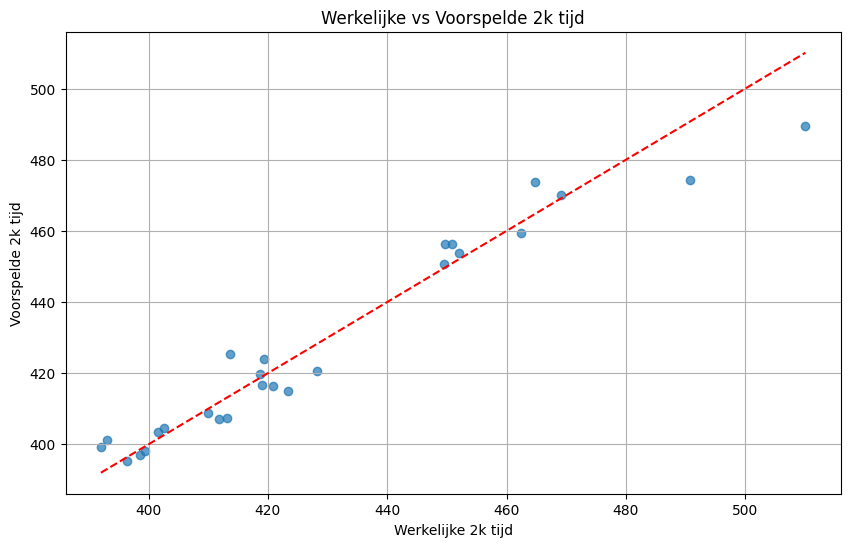

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Stap 1: Data inlezen
df = pd.read_csv('final_gemid_df.csv')

# Stap 2: Data aggregatie per roeier (unique_naam)
def aggregate_features(group):
    return pd.Series({
        'avg_500_split': group['500_split'].mean(),
        'std_500_split': group['500_split'].std(),
        'min_500_split': group['500_split'].min(),
        'max_500_split': group['500_split'].max(),
        'num_trainings': group['trainingtype'].nunique(),
        'avg_trainingtype': group['binary_trainingtype'].mean(),
        'avg_experience': group['ervaring'].mean(),
        'binary_geslacht': group['binary_geslacht'].iloc[0],
        'binary_gewichtsklasse': group['binary_gewichtsklasse'].iloc[0],
        'avg_2k_time': group['2k tijd'].mean(),
    })

aggregated_df = df.groupby('unique_naam').apply(aggregate_features).reset_index()

# Stap 3: Data splitsen in features en target
X = aggregated_df.drop(columns=['unique_naam', 'avg_2k_time'])
y = aggregated_df['avg_2k_time']

# Splitsen in train-, validatie- en testsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Stap 4: XGBoost model instellen en trainen
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    reg_lambda=10,
    min_child_weight=3,
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=7,  # Beperkte boomdiepte
    n_estimators=300  # Aantal bomen
)

xgb_model.fit(X_train, y_train)

# Stap 5: Model evalueren
train_pred = xgb_model.predict(X_train)
val_pred = xgb_model.predict(X_val)
test_pred = xgb_model.predict(X_test)

train_mse = (mean_squared_error(y_train, train_pred))
val_mse = (mean_squared_error(y_val, val_pred))
test_mse = (mean_squared_error(y_test, test_pred))

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

# Resultaten printen
print("Train MSE: ", train_mse)
print("Train RMSE: ", train_rmse)
print("Train R2: ", train_r2)

print("Validation MSE: ", val_mse)
print("Validation RMSE: ", val_rmse)
print("Validation R2: ", val_r2)

print("Test MSE: ", test_mse)
print("Test RMSE: ", test_rmse)
print("Test R2: ", test_r2)


# Stap 6: Optionele visualisatie van resultaten
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Werkelijke 2k tijd')
plt.ylabel('Voorspelde 2k tijd')
plt.title('Werkelijke vs Voorspelde 2k tijd')
plt.grid(True)
plt.show()


/tmp/ipykernel_12454/2024237753.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_df = df.groupby('unique_naam').apply(aggregate_features).reset_index()


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Beste parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 0.8}
{'Train RMSE': 0.47755716943332865, 'Validation RMSE': 9.290415135534808, 'Test RMSE': 8.057600047958156, 'Train R2': 0.9997880751412668, 'Validation R2': 0.9192684729696303, 'Test R2': 0.9318171284792421}


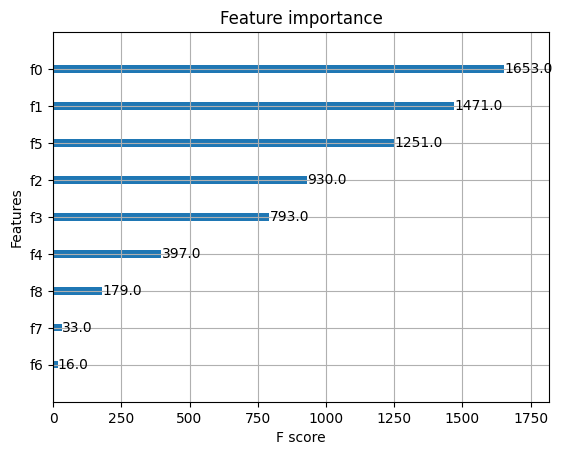

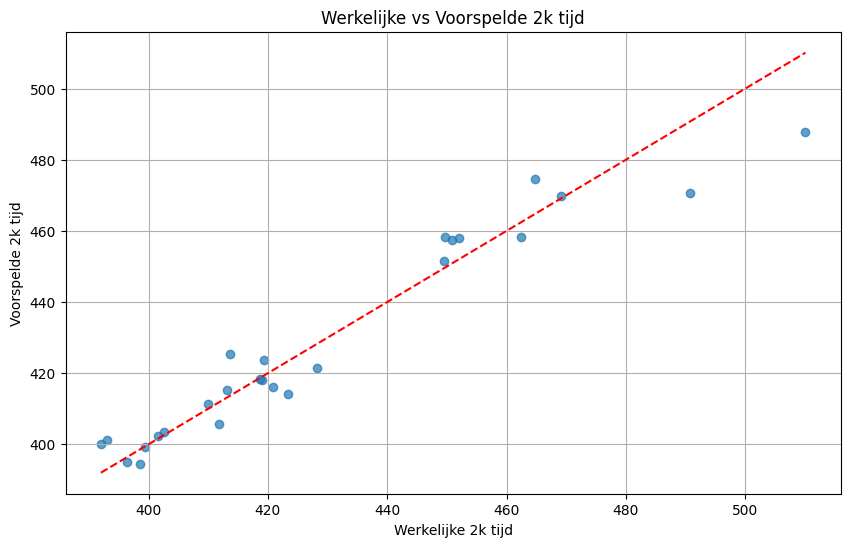

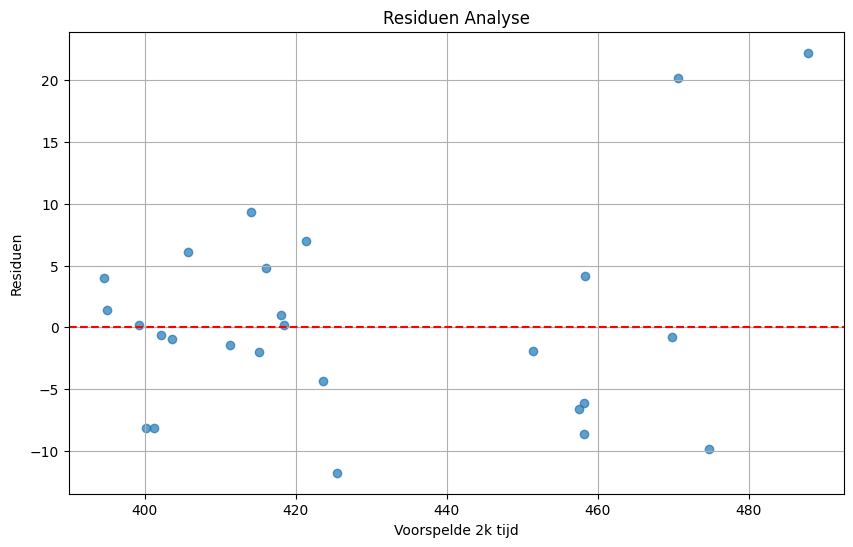

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Stap 1: Data inlezen
df = pd.read_csv('final_gemid_df.csv')

# Stap 2: Data aggregatie per roeier (unique_naam)
def aggregate_features(group):
    return pd.Series({
        'avg_500_split': group['500_split'].mean(),
        'std_500_split': group['500_split'].std(),
        'min_500_split': group['500_split'].min(),
        'max_500_split': group['500_split'].max(),
        'num_trainings': group['trainingtype'].nunique(),
        'avg_trainingtype': group['binary_trainingtype'].mean(),
        'avg_experience': group['ervaring'].mean(),
        'binary_geslacht': group['binary_geslacht'].iloc[0],
        'binary_gewichtsklasse': group['binary_gewichtsklasse'].iloc[0],
        'avg_2k_time': group['2k tijd'].mean(),
    })

aggregated_df = df.groupby('unique_naam').apply(aggregate_features).reset_index()

# Log-transformatie van skewed features
for col in ['avg_500_split', 'std_500_split', 'max_500_split']:
    aggregated_df[f'log_{col}'] = np.log1p(aggregated_df[col])

# Stap 3: Data splitsen in features en target
X = aggregated_df.drop(columns=['unique_naam', 'avg_2k_time'])
y = aggregated_df['avg_2k_time']

# Schalen (optioneel, afhankelijk van XGBoost-configuratie)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitsen in train-, validatie- en testsets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Stap 4: Grid Search voor hyperparameter-tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 1],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Beste parameters printen
print("Beste parameters:", grid_search.best_params_)

# Stap 5: Evaluatie op testset
best_model = grid_search.best_estimator_

train_pred = best_model.predict(X_train)
val_pred = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

results = {
    "Train RMSE": train_rmse,
    "Validation RMSE": val_rmse,
    "Test RMSE": test_rmse,
    "Train R2": train_r2,
    "Validation R2": val_r2,
    "Test R2": test_r2,
}
print(results)

# Stap 6: Feature Importance visualiseren
plot_importance(best_model, importance_type='weight')
plt.show()

# Stap 7: Werkelijke vs voorspelde waarden plotten
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Werkelijke 2k tijd')
plt.ylabel('Voorspelde 2k tijd')
plt.title('Werkelijke vs Voorspelde 2k tijd')
plt.grid(True)
plt.show()

# Residuen plotten
residuals = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Voorspelde 2k tijd')
plt.ylabel('Residuen')
plt.title('Residuen Analyse')
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load the data
# Assuming your dataset is already in a DataFrame called `data`
# If it's stored in a file:
# data = pd.read_csv("your_data.csv")

# Step 2: Define features (X) and target (y)
X = df.drop(columns=['unique_naam', '2k_tijd'])  # Drop target and non-numeric identifiers
y = df['2k_tijd']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


KeyError: "['2k_tijd'] not found in axis"

In [16]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor

# 1. Feature Engineering op individuele trainingen
def feature_engineering(df):
    df['interaction_split_training'] = df['500_split'] * df['binary_trainingtype']
    df['interaction_split_geslacht'] = df['500_split'] * df['binary_geslacht']
    df['interaction_split_ervaring'] = df['500_split'] * df['ervaring']
    df['log_500_split'] = np.log1p(df['500_split'])  # Log-transform voor skewness
    return df

data = feature_engineering(data)

# 2. Per roeier alle trainingen aggregeren
aggregated_features = data.groupby('unique_naam').agg({
    '500_split': ['mean', 'std', 'min', 'max'],
    'ervaring': ['mean'],
    'binary_trainingtype': ['mean'],
    'binary_geslacht': ['mean'],
    'binary_gewichtsklasse': ['mean'],
    '2k tijd': ['mean']  # Target kolom
})

# Kolomnamen hernoemen
aggregated_features.columns = ['_'.join(col).strip() for col in aggregated_features.columns]
aggregated_features = aggregated_features.reset_index()

# 3. Train-test split
from sklearn.model_selection import train_test_split

X = aggregated_features.drop(columns=['2k tijd_mean'])
y = aggregated_features['2k tijd_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. XGBoost model trainen
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    reg_lambda=10,
    min_child_weight=3,
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=300
)

xgb_model.fit(X_train.drop(columns=['unique_naam']), y_train)

# 5. Voorspellingen maken
train_pred = xgb_model.predict(X_train.drop(columns=['unique_naam']))
test_pred = xgb_model.predict(X_test.drop(columns=['unique_naam']))

# 6. Evaluatie
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Train R2: {train_r2:.3f}")
print(f"Test R2: {test_r2:.3f}")

# 7. Resultaten opslaan en bekijken
results_xgb = pd.DataFrame({
    'Unique Naam': X_test['unique_naam'],
    'Actual 2k Tijd': y_test,
    'Predicted 2k Tijd': test_pred,
    'Difference': y_test - test_pred
})
print(results_xgb.head())

Train RMSE: 1.391
Test RMSE: 8.419
Train R2: 0.998
Test R2: 0.936
    Unique Naam  Actual 2k Tijd  Predicted 2k Tijd  Difference
76     d51_2022          479.20         485.918854   -6.718854
138     z2_2019          398.70         397.988190    0.711810
152    z41_2018          398.94         401.693604   -2.753604
60     d39_2019          462.40         452.581055    9.818945
156    z45_2018          413.20         408.188416    5.011584
